In [2]:
import pandas as pd, numpy as np
% matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm_pandas
import time
import warnings
warnings.filterwarnings('ignore')
import gc
from scipy.stats import norm, rankdata

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int16)
    return df

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

train = downcast_dtypes(train)
test = downcast_dtypes(test)

data = pd.concat([train, test], axis=0, sort=False)

data.shape

(200000, 202)
(200000, 201)


In [6]:
col_var = train.columns[2:]
df = pd.DataFrame(col_var, columns=['feature'])
df['n_train_unique'] = train[col_var].nunique(axis=0).values
df['n_test_unique'] = test[col_var].nunique(axis=0).values

for i in df.index:
    col = df.loc[i, 'feature']
    df.loc[i, 'n_overlap'] = int(np.isin(train[col].unique(), test[col]).sum())

df['value_range'] = data[col_var].max(axis=0).values - data[col_var].min(axis=0).values

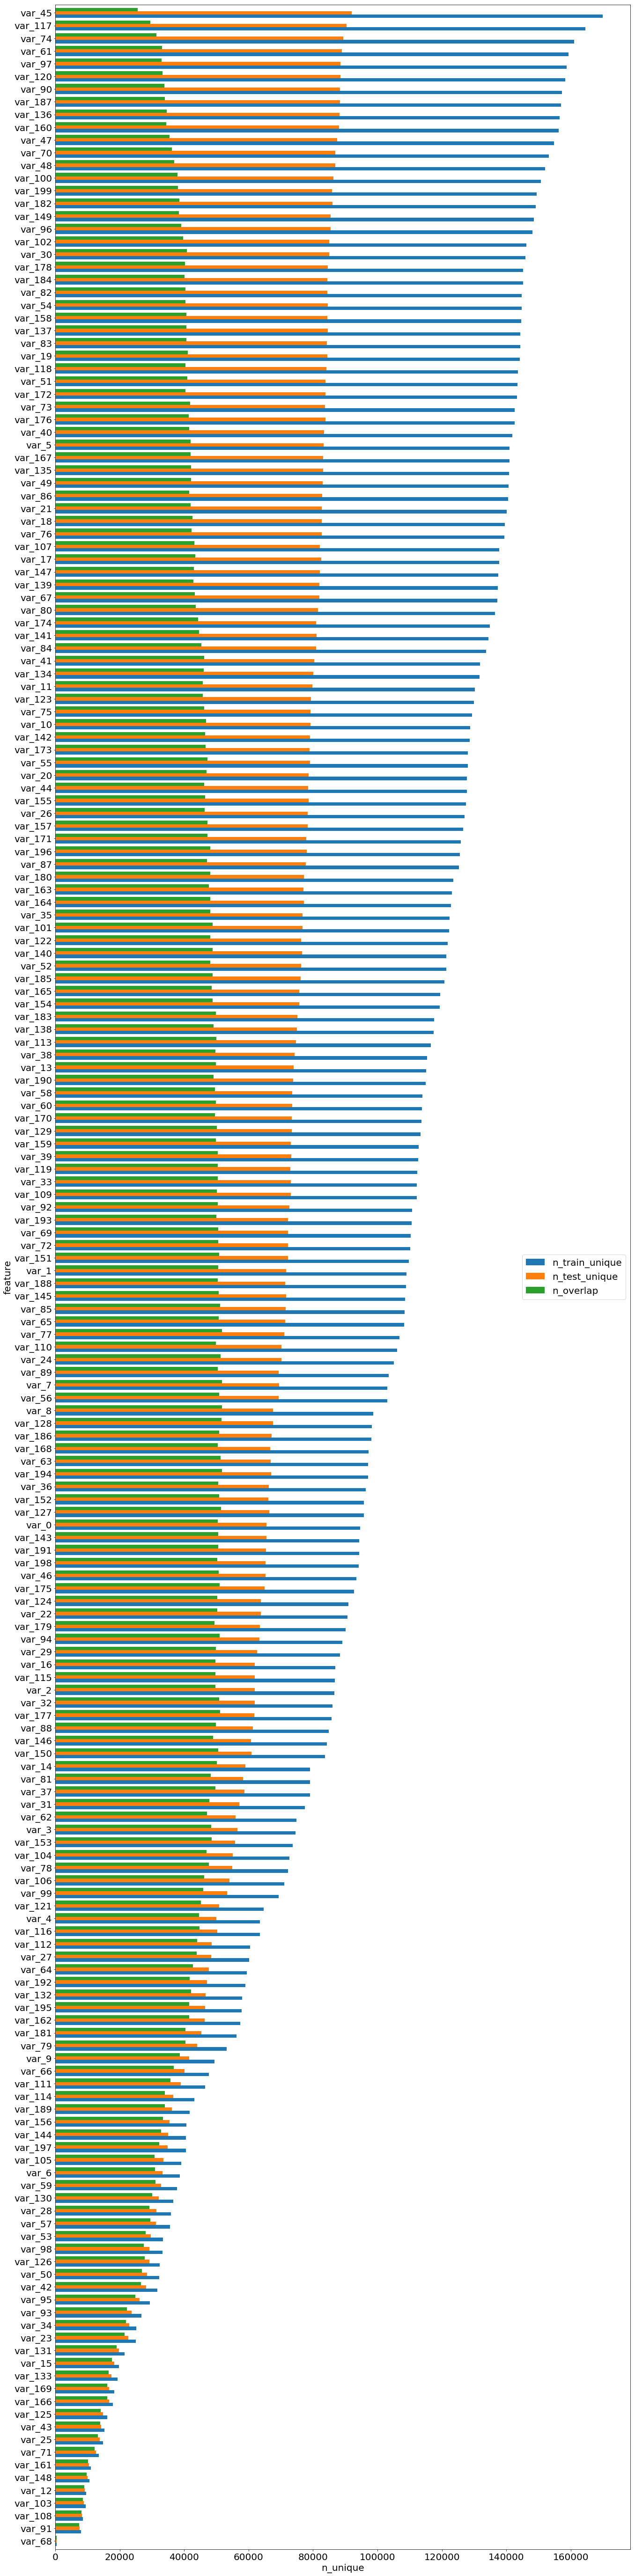

In [26]:
df = df.sort_values(by='n_train_unique').reset_index(drop=True)
df[['n_train_unique', 'n_test_unique', 'n_overlap']].plot(kind='barh' ,figsize=(22, 100), fontsize=20, width=0.8)
plt.yticks(df.index, df['feature'].values)
plt.xlabel('n_unique', fontsize=20)
plt.ylabel('feature', fontsize=20)
plt.legend(loc='center right', fontsize=20)

### Several methods for research
1. GAM
2. Keras, Pytorch
3. XGBoost, LGBM, CatBoost (bin those numerical values using qcat)
4. Try models in PyMC
5. Try models in Edward 
6. Tune using hyperopt

### Modeling strategy
1. Use StratifiedKFold
2. First level model: LogisticRegression, LGBMClassifier, DL-Keras

### Submission List (remember to test on validation dataset!)
1. M level 1 features from M diverse sklearn models. Level 2 model could be just one model.
2. Same with 1 but level 2 models are level 1 models, the predictions then averaged.
3. Same with 1 but now add LGBM, XGBoost, CatBoost to the 1st level model. Each model has 2 type of training: all numerical features and categorical features from binned numerical features.
4. Same with 3 but level 2 models are all models in step 3, the predictions then averaged.
5. Same with 3 but now add DL Keras model.
6. Same with 5 but level 2 models are all models in step 5, the predictions then averaged.
7. Add LogisticGAM and Edward models.
8. Do feature engineering
9. Repeat step 1-7
10. Try feature selection using RFE and stepwise on R or Firth logistic regression.
11. Add weak learners

In [99]:
from sklearn.linear_model import (LogisticRegression, 
                                  SGDClassifier,
                                  RandomizedLogisticRegression
                                 )
from sklearn.ensemble import (AdaBoostClassifier, 
                              GradientBoostingClassifier,
                              RandomForestClassifier,
                              ExtraTreesClassifier,
                              BaggingClassifier)
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.lda import LDA
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, 
                                           QuadraticDiscriminantAnalysis)
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.qda import QDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold, train_test_split as tts
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import roc_auc_score, auc, roc_curve

In [29]:
target = train.pop('target')
train_ids = train.pop('ID_code')
test_ids = test.pop('ID_code')
len_train = len(train)
merged = pd.concat([train, test])
del test, train
gc.collect()

35

In [87]:
original_features = merged.columns

for col in original_features:
    merged[col] = ((merged[col]-merged[col].mean()) 
                   / merged[col].std()).astype('float32')
    merged[col + '^2'] = merged[col] * merged[col]
    merged[col + '^3'] = merged[col] * merged[col] * merged[col]
    merged[col + '^4'] = merged[col] * merged[col] * merged[col] * merged[col]
    merged[col + '_cp'] = rankdata(merged[col]).astype('float32')
    merged[col + '_cdf'] = norm.cdf(merged[col]).astype('float32')
    
new_features = set(merged.columns) - set(original_features)

In [ ]:
train = merged.iloc[:len_train]
test = merged.iloc[:len_train]

In [96]:
train_spl = train.sample(n=12000, random_state=seed)
y_train_spl = target.sample(n=12000, random_state=seed)
sc = StandardScaler()
train_spl = sc.fit_transform(train_spl)

X_train, X_test, y_train, y_test = tts(train_spl, y_train_spl, test_size=0.3, stratify=y_train_spl)
bagknn = bag(knn)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

In [158]:
c3v = CalibratedClassifierCV(cv=5, base_estimator=rf, method='isotonic')
c3v.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=92,
            verbose=0, warm_start=False),
            cv=5, method='isotonic')

In [157]:
roc_auc_score(y_test, c3v.predict_proba(X_test)[:, 1])

0.7913890442343379

In [159]:
roc_auc_score(y_test, c3v.predict_proba(X_test)[:, 1])

0.7908407063046211

In [140]:
seed = 92
n_trees = 100
sample_size = 20000
n_bags = 2

# NANTI BIKIN LAGI CUMAN PAKE UNDERSAMPLING & OVERSAMPLING IMBLEARN

lrl2 = LogisticRegression(random_state=seed, class_weight='balanced', 
                          C=0.5, solver='lbfgs', max_iter=100)
lrl1 = LogisticRegression(random_state=seed, class_weight='balanced', C=10, 
                          penalty='l1', solver='saga', max_iter=100)
sgdlog = SGDClassifier(random_state=seed, class_weight='balanced', loss='log', 
                       max_iter=500, early_stopping=True, n_jobs=-1)
sgdhuber = SGDClassifier(random_state=seed, class_weight='balanced', loss='modified_huber', 
                         max_iter=500, early_stopping=True, n_jobs=-1)
adadt = AdaBoostClassifier(random_state=seed, n_estimators=n_trees)
adaet = AdaBoostClassifier(random_state=seed, n_estimators=n_trees, base_estimator=ExtraTreeClassifier)
gb = GradientBoostingClassifier(random_state=seed, n_estimators=n_trees)
rf = RandomForestClassifier(n_estimators=n_trees, random_state=seed, class_weight='balanced', n_jobs=-1)
ets = ExtraTreesClassifier(n_estimators=n_trees, random_state=seed, class_weight='balanced', n_jobs=-1)
bag = BaggingClassifier(n_estimators=20, random_state=seed, n_jobs=-1)
bgm = BayesianGaussianMixture(random_state=seed) # weird result
gm = GaussianMixture(random_state=seed) # weird result
c3v = CalibratedClassifierCV(cv=5, base_estimator=lrl2)
et = ExtraTreeClassifier(random_state=seed, class_weight='balanced')
dt = DecisionTreeClassifier(random_state=seed, class_weight='balanced')
gpc = GaussianProcessClassifier(random_state=seed, n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
ldan = LinearDiscriminantAnalysis(shrinkage='auto') # tweak the prior param
qdan = QuadraticDiscriminantAnalysis()
mlp = MLPClassifier(random_state=seed)

In [103]:
def bagging(base_estimator):
    bc = BaggingClassifier(random_state=seed, n_estimators=7,
                           base_estimator=base_estimator, n_jobs=-1,
                           max_features=.85, max_samples=.85)
    return bc

classifiers = [sgdhuber, sgdlog, adadt, adaet, gb, 
               rf, ets, c3v, knn, ldan, lrl1, lrl2]
bags = [bagging(clf) for clf in classifiers]

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
train_meta, test_meta = [], []

for val_idx, tr_idx in skf.split(train_spl, y_train_spl):
    X_train, y_train = train_spl[tr_idx], y_train_spl[tr_idx]
    X_valid, y_valid = train_spl[val_idx], y_train_spl[val_idx]
    for bag in bags:
        bag.fit(X_train, y_train)
        val_preds = bag.predict_proba(X_valid)[:, 1]
        test_preds = bag.predict_proba(X_test)[:, 1] # coming soon
        val_auc = roc_auc_score(y_valid, val_preds)
        base_name = bag.base_estimator.__class__.__name__
        print("AUC of bag {} on validation = {:.3f}".format(base_name, val_auc))
        train_meta.append(val_preds)
        test_meta.append(test_preds)
    X_meta_features = np.hstack(train_meta)
    test_meta = np.hstack(test_meta) # coming soon
    break
    
y_meta_features = y_train_spl[val_idx]
lrl1.fit(X_meta_features, y_meta_features)
y_preds = lrl1.predict_proba(test_meta)

In [121]:
bagrf = BaggingClassifier(base_estimator=rf, random_state=seed, 
                          n_jobs=-1, n_estimators=n_bags, 
                          max_samples=0.8, max_features=0.8)
bagets = BaggingClassifier(base_estimator=ets, random_state=seed, 
                           n_jobs=-1, n_estimators=n_bags,
                           max_samples=0.8, max_features=0.8)
baggb = BaggingClassifier(base_estimator=gb, random_state=seed, 
                          n_jobs=-1, n_estimators=n_bags,
                         max_samples=0.8, max_features=0.8)
bagmlp = BaggingClassifier(base_estimator=mlp, random_state=seed, 
                           n_jobs=-1, n_estimators=n_bags,
                          max_samples=0.8, max_features=0.8)
bagada = BaggingClassifier(base_estimator=ada, random_state=seed, 
                           n_jobs=-1, n_estimators=n_bags,
                          max_samples=0.8, max_features=0.8)
bagldan = BaggingClassifier(base_estimator=ldan, random_state=seed, 
                            n_jobs=-1, n_estimators=n_bags,
                           max_samples=0.8, max_features=0.8)
bagsgdlog = BaggingClassifier(base_estimator=sgdlog, random_state=seed, 
                              n_jobs=-1, n_estimators=n_bags,
                              max_samples=0.8, max_features=0.8)
bagsgdhuber = BaggingClassifier(base_estimator=sgdhuber, random_state=seed, 
                              n_jobs=-1, n_estimators=n_bags,
                              max_samples=0.8, max_features=0.8)
baglr2 = BaggingClassifier(base_estimator=lrl2, random_state=seed, 
                           n_jobs=-1, n_estimators=n_bags,
                           max_samples=0.8, max_features=0.8)
baglr1 = BaggingClassifier(base_estimator=lrl1, random_state=seed, 
                           n_jobs=-1, n_estimators=n_bags,
                           max_samples=0.8, max_features=0.8)
bagc3v = BaggingClassifier(base_estimator=c3v, random_state=seed, 
                           n_jobs=-1, n_estimators=n_bags,
                          max_samples=0.8, max_features=0.8)
bagknn = BaggingClassifier(base_estimator=knn, random_state=seed, 
                           n_jobs=-1, n_estimators=n_bags,
                          max_samples=0.8, max_features=0.8)

classifiers = [
#     bagrf, bagets,
#                baggb, 
               baglr1,
#                baglr2,
#                bagada, bagldan, 
#                bagsgdlog, bagmlp, 
#                bagc3v, bagsgdhuber
              ]

auc_all = []
auc_model = {clf.base_estimator.__class__.__name__: [] for clf in classifiers}

for cohort in tqdm_notebook(range(10)):
    print('Training models at random fold of %d' %(cohort+1))
    train_spl = pd.concat([train, pd.DataFrame(y, columns=['target'])], axis=1).sample(n=sample_size)
    train_X = train_spl.drop(labels=['target'], axis=1)
    train_y = train_spl.target.values
    X_train, X_test, y_train, y_test = tts(train_X, train_y, stratify=train_y, test_size=0.3)
    
    for model in tqdm_notebook(classifiers):
        start_time = time.time()
        model.fit(X_train, y_train)
        model_name = model.base_estimator.__class__.__name__
        y_pred = model.predict_proba(X_test)[:, 1]
        print("Elapsed time to build bag of {} is {:.3f} s".format(model_name, time.time()-start_time))
        auc_score = roc_auc_score(y_test, y_pred)
        auc_model[model_name].append(auc_score)
        print('AUC score for {} is {:.3f}'.format(model_name, auc_score))
        print('-' * 50)
    
    auc_all.append(auc_model)

Training models at random fold of 1





Elapsed time to build bag of LogisticRegression is 129.985 s
AUC score for LogisticRegression is 0.759
--------------------------------------------------
Training models at random fold of 2


Elapsed time to build bag of LogisticRegression is 123.274 s
AUC score for LogisticRegression is 0.779
--------------------------------------------------
Training models at random fold of 3


KeyboardInterrupt: 

In [150]:
auc_mean_2 = {clf.base_estimator.__class__.__name__: 0 for clf in classifiers}
for auc in auc_all:
    for clf in auc_mean_2.keys():
        auc_mean_2[clf] = np.mean(auc[clf])

In [145]:
auc_mean

{'AdaBoostClassifier': 0.8492582498425414,
 'CalibratedClassifierCV': 0.8437500082464426,
 'ExtraTreesClassifier': 0.8316169079843173,
 'GradientBoostingClassifier': 0.8261273886307786,
 'LinearDiscriminantAnalysis': 0.8449133439022898,
 'LogisticRegression': 0.840076004723085,
 'MLPClassifier': 0.8312319200449314,
 'RandomForestClassifier': 0.8302612420192522,
 'SGDClassifier': 0.824526541369347}

In [155]:
auc_mean_2 # bagging 80% of the dataset and features, n_dataset = 20000

{'AdaBoostClassifier': 0.8542975711909395,
 'CalibratedClassifierCV': 0.8476261336274271,
 'ExtraTreesClassifier': 0.834116453936191,
 'GradientBoostingClassifier': 0.8368486243774969,
 'LinearDiscriminantAnalysis': 0.8470432748382495,
 'LogisticRegression': 0.8436048440199858,
 'MLPClassifier': 0.8166854691275027,
 'RandomForestClassifier': 0.831397421992078,
 'SGDClassifier': 0.8161056052294114}

In [154]:
for clf in auc_mean.keys():
    print('Comparing two models of {}'.format(clf))
    print(auc_mean_2[clf] > auc_mean[clf])

Comparing two models of RandomForestClassifier
True
Comparing two models of ExtraTreesClassifier
True
Comparing two models of GradientBoostingClassifier
True
Comparing two models of LogisticRegression
True
Comparing two models of AdaBoostClassifier
True
Comparing two models of LinearDiscriminantAnalysis
True
Comparing two models of SGDClassifier
False
Comparing two models of MLPClassifier
False
Comparing two models of CalibratedClassifierCV
True


### Tune parameter using hyperopt for each model!

In [25]:
from hyperopt import tpe, hp, fmin, STATUS_OK

train_spl = train.sample(n=5000, random_state=92)
X_train = train_spl.drop(['target','ID_code'],axis=1).values
y_train = train_spl.target.values

def objective_func_lr(args):
    if args['model'] == LogisticRegression:
        C = args['param']['C']
#         fit_intercept = args['param']['fit_intercept']
        clf = LogisticRegression(C=C, 
#                                  fit_intercept=fit_intercept, 
                                 class_weight='balanced')
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict_proba(X_train)[:,1]
        auc_train = roc_auc_score(y_train, y_pred_train)
        print("Train AUC:", auc_train)
        print('=' * 50)
        return auc_train
    else:
        return None

space_lr = {'model': LogisticRegression, 
            'param': {'C': hp.loguniform('C', np.log10(1e-1), np.log10(1)), 
#             'fit_intercept': hp.choice('fit_intercept', [False, True]), 
#             'penalty': hp.choice('penalty', ['l1', 'l2']), 
#             'solver': hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
           }}

lr_hyperopt = fmin(objective_func_lr, space_lr, algo=tpe.suggest, max_evals=100)
print(lr_hyperopt)

Train AUC: 0.902493897801358
Train AUC: 0.9025535781368261
Train AUC: 0.902465676867532
Train AUC: 0.9025438627333779
Train AUC: 0.9025239692882218
Train AUC: 0.9024351427424085
Train AUC: 0.902527207756038
Train AUC: 0.9024804812918342
Train AUC: 0.9025526528603074
Train AUC: 0.9025480264777128
Train AUC: 0.902481406568353
Train AUC: 0.9025050011195845
Train AUC: 0.9025174923525896
Train AUC: 0.9024550361875647
Train AUC: 0.9024837197596501
Train AUC: 0.9025572792429017
Train AUC: 0.9024434702310786
Train AUC: 0.902539698989043
Train AUC: 0.9024328295511114
Train AUC: 0.9024860329509473
Train AUC: 0.9024286658067765
Train AUC: 0.902452260358008
Train AUC: 0.9024536482727863
Train AUC: 0.9024305163598143
Train AUC: 0.9024554988258241
Train AUC: 0.9025105527786978
Train AUC: 0.9024522603580081
Train AUC: 0.9024476339754135
Train AUC: 0.9024309789980736
Train AUC: 0.9024999120987307
Train AUC: 0.9024531856345268
Train AUC: 0.9024332921893709
Train AUC: 0.9025110154169573
Train AUC: 0.902

{'C': 0.22748966527428796}

In [74]:
parameters = {'C': [15, 50, 100], 
#               'fit_intercept': [True, False]
             }
lr = LogisticRegression(class_weight='balanced', penalty='l1', solver='saga', max_iter=400)
clf = GridSearchCV(lr, parameters, cv=5, verbose=10, n_jobs=-1, scoring='roc_auc')
train_spl = train.sample(n=125000, random_state=92)
X_train = train_spl.drop(['target','ID_code'],axis=1).values
y_train = train_spl.target.values
clf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 13.2min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 13.3min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 16.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=400,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [15, 50, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc',
       verbose=10)

In [73]:
train_spl = train.sample(n=200000)
X_train = train_spl.drop(['target','ID_code'],axis=1).values
y_train = train_spl.target.values

print(clf.score(X_train, y_train))

0.8602395449101108
